# <center> Обучение с учителем. Классификация
## <center> Предсказываем категорию дохода человека
<center> <img src=https://blondeblog.ru/wp-content/uploads/2018/09/2.jpg.jpg width=400>

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

C:\Users\insps\AppData\Local\Temp\ipykernel_20592\4088794267.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Описание задачи

Данные, с которыми мы будем работать, были извлечены из базы данных **Бюро переписи населения 1994 года** Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной — предсказание дохода.

Мы будем использовать версию датасета, где доход участников переписи разделён на две категории: больше и меньше (либо равен) 50K $.


### Знакомство с данными и их исследование

In [2]:
data = pd.read_csv('https://lms.skillfactory.ru/assets/courseware/v1/4e328aa4b2399734114af65f79fab028/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ML-3_adult.zip')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


**Признаки:**
* age — возраст;
* workclass — статус занятости;
* fnlwgt — общий вес (число людей, которые, по мнению эксперта, относятся к этой категории занятости);
* education — образование;
* education.num — образовательная ступень (в виде числа);
* marital.status — семейное положение;
* occupation — профессия;
* relationship — тип отношений;
* race — расовая принадлежность;
* sex — пол;
* capital.gain — ежегодный дополнительный прирост капитала;
* capital.loss — ежегодная дополнительная потеря капитала;
* hours.per.week — число рабочих часов в неделю;
* native.country — страна рождения;
* income — категория дохода (целевой признак).

Проверяем наличие пропусков:

In [3]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [4]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


Смотрим на сбалансированность классов:

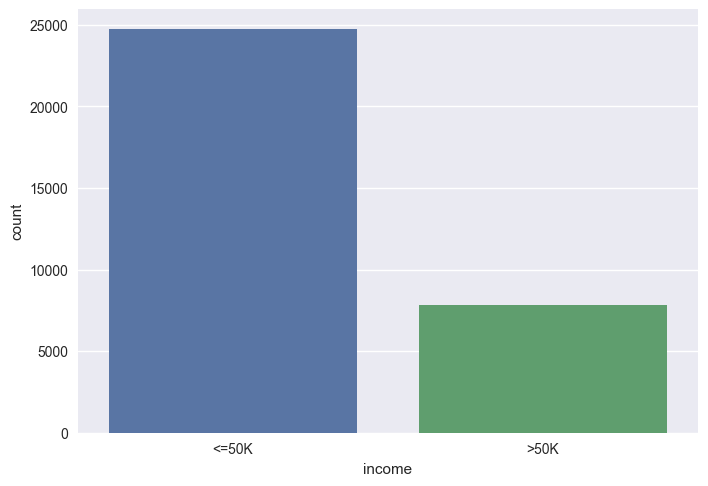

In [5]:
sns.countplot(data=data, x='income');

Для удобства переобозначим целевой признак (необязательный шаг):

In [6]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

Исследуем категориальные признаки

In [7]:
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

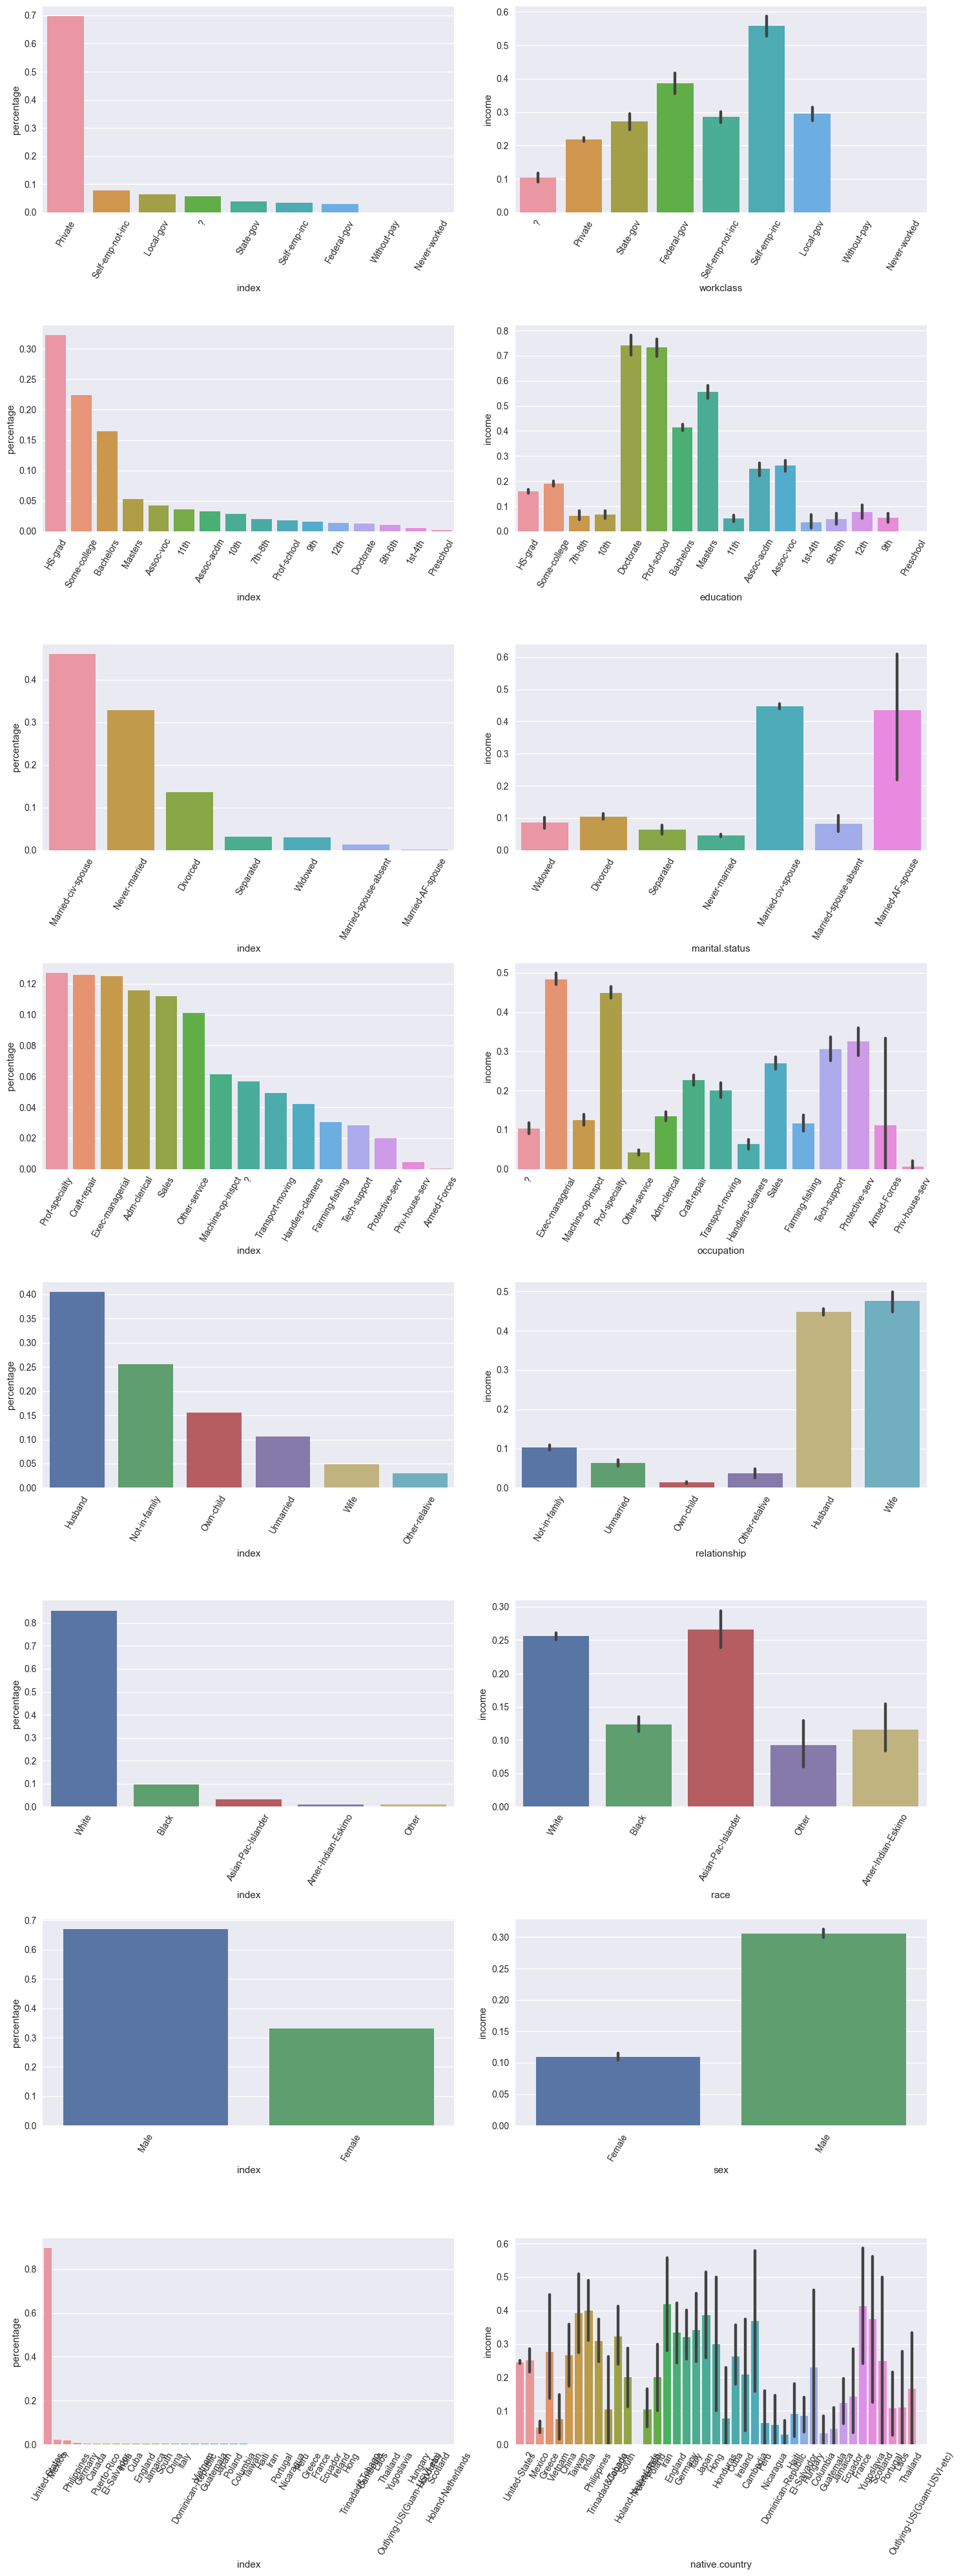

In [8]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих > 50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Подготовка данных (предобработка)

Предобрабатываем категориальые признаки: уменьшаем количество категорий

In [9]:
adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Wife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

Предобрабатываем числовые признаки

In [10]:
#Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [ ]:
#Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

Проверяем результаты предобработки

In [11]:
adult_data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,17800,27816,21790,29170


Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

C:\Users\insps\AppData\Local\Temp\ipykernel_20592\2513722898.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(adult_data.corr(), annot = True);


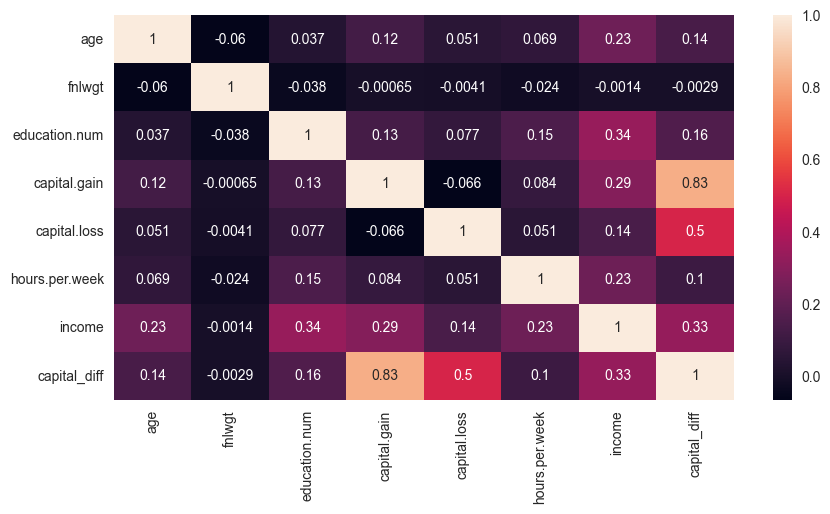

In [12]:
plt.figure(figsize = (10, 5))
sns.heatmap(adult_data.corr(), annot = True);

Кодируем текстовые категориальные признаки

In [13]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,9,0.0,8.379539,40,0,8.379539,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,9,0.0,8.379539,18,0,8.379539,0,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,10,0.0,8.379539,40,0,8.379539,0,0,...,0,0,0,1,0,1,0,0,0,1
3,54,11.851966,4,0.0,8.268988,40,0,8.268988,0,0,...,0,0,0,1,0,0,0,1,0,1
4,41,12.486216,10,0.0,8.268988,40,0,8.268988,0,0,...,0,0,0,1,0,0,0,1,0,1


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [14]:
X = dummies_data.drop(['income'], axis=1)
y = dummies_data['income']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Производим нормализацию данных с помощью min-max нормализации

In [16]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Моделирование + оценка модели

#### Логистическая регрессия

**Модель логистической регрессии:**

Модель логистической регрессии имеет следующий вид:
$$z_i= w_0+\sum_{j=0}^m w_j x_{ij}$$

$$\widehat{P_i}= \frac{1}{1+exp(-z_i)}$$

$$\widehat{y_i} = I_\gamma[\widehat{P_i}]$$

где $x_{ij}$ — объект из $i$-ой строки и $j$-ого столбца из таблицы объектов-признак $X$, $y_i$ — правильный ответ, соответствующий $x_{i}$, $\omega$ — параметры логистической регрессии, $\widehat{P_i}$ - вероятность принадлежности к классу, $\gamma$ - порог вероятности (стандартный - 0.5)

Для поиска параметров модели используется схема минимизации эмпиричного риска - ищутся такие параметры $\omega$, при которых функция ошибки $L(\omega)$ была бы минимальна. 


В качестве функции потерь используем logloss - логистическая функция потерь.

$$L(\omega) = logloss = -\sum_{i=1}^{n}{(y_i log(\widehat{P_i}) + (1-y_i)log(1-\widehat{P_i}))} \Rightarrow min_\omega $$

Поиск параметров можно проводить с помощью численных методов. Например, градиентного спуска

In [17]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=1, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='sag')

Выводим отчет по метрикам для тренировочной и тестовой выборок

In [18]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     19775
           1       0.72      0.58      0.64      6273

    accuracy                           0.84     26048
   macro avg       0.80      0.75      0.77     26048
weighted avg       0.84      0.84      0.84     26048

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4945
           1       0.72      0.58      0.65      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.76      0.77      6513
weighted avg       0.84      0.85      0.84      6513



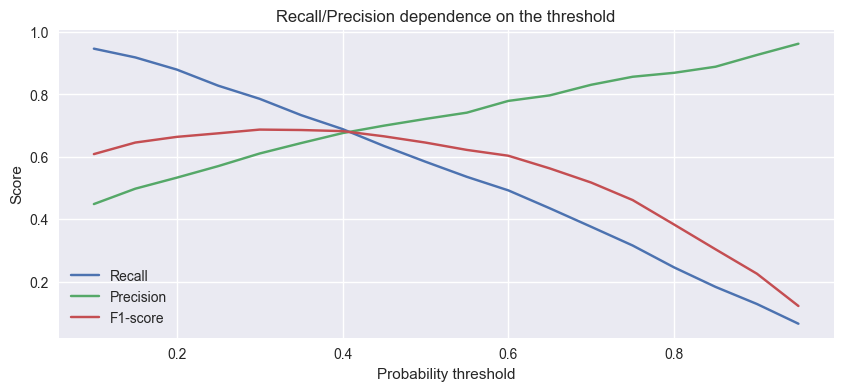

In [20]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = log_reg.predict_proba(X_test_scaled)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [21]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.4
#Людей, у которых вероятность зарабатывать >50K больше 0.4 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4945
           1       0.68      0.69      0.68      1568

    accuracy                           0.85      6513
   macro avg       0.79      0.79      0.79      6513
weighted avg       0.85      0.85      0.85      6513



#### Дерево решений

Дерево решений - ациклический связный граф. 

Построение дерева решений происходит по рекурсивному алгоритму $CART$ (псевдокод приведен в модуле).

В каждой вершине дерева задается решающее правило или предикат вида:

$$B_v(j, t) = I[x_j<= t]$$

Где $B_v$ - предикат в вершине под номер $v$, $j$ - номер признака, $t$ - пороговое значение признака 
Предикат разделяет выборку на две части: $Q_{left}$ - для которой условие верно, и $Q_{right}$ - для которой условие ложно.

На основе разделения выборки вершина порождает все новые вершины: левую и правую, для каждой из которых алгоритм повторяется, пока не выполнится некоторый критерий остановки.

Критерии остановки:
* достигнутая максимальная глубина (max_depth)
* количество наблюдений в листе меньше заданного числа (min_sample_leaf)
* неопределенность (функция ошибки) $L(j, t)$ в вершине равна 0 - все объекты, попавшие в вершину принадлежат одному классу.



Параметры $j$ и $t$ подбираются полным перебором (в sklearn он оптимизированы). Из всех возможных значений выбираются такие параметры, при которых функция ошибки (суммарная неопределенность) минимальна:
$$L(j, t)= \frac{n^{left}_v}{n_v} H(Q_{left}) + \frac{n^{right}_v}{n_v} H(Q_{right})  \Rightarrow min_{j, t} $$

Где $n^{left}_v$ и $n^{right}_v$ - размер выборок, попавших в левую и правую вершину соответственно 

$H(Q)$ называется критерием информативности. И он может быть двух видов:
1. Энтропия Шеннона:
$$H(Q) = \sum_{i=1}^{k}P_i log_2{P_i} $$
2. Критерий Джини:
$$H(Q) = \sum_{i=1}^{k}P_i (1-P_i) $$

In [ ]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    #min_samples_leaf=5,
    max_depth=8,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.67
Test: 0.64


In [ ]:
# #Создаем фигуру для визуализации графа
# fig = plt.figure(figsize=(25,20))
# #Строим граф дерева решений
# tree_graph = tree.plot_tree(
#     dt, #объект обученного дерева
#     feature_names=X_train.columns, #наименования факторов
#     class_names=["0 - <=50K", "1 - >50K"], #имена классов
#     filled=True, #расцветка графа
# );

#### Бэггинг. Случайный лес

**Бэггинг (bagging)** - алгоритм построения ансамбля путем параллельного обучения множества независимых друг от друга моделей. Предсказание для новых данных производится путем мажоритарного голосования или усреднения ответов

**Случайный лес (Random Forest)** - частный случай бэггинга над деревьями решений с методом случайных подпространств

In [ ]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    criterion='entropy',
    min_samples_leaf=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.67
Test: 0.67


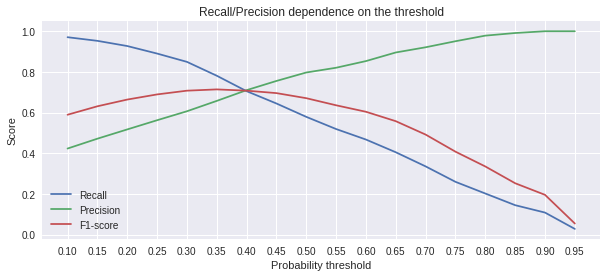

In [ ]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = rf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.set_xticks(thresholds)
ax.legend();

In [ ]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.4
#Людей, у которых вероятность зарабатывать >50K больше 0.4 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      4945
           1       0.71      0.71      0.71      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.81      0.81      6513
weighted avg       0.86      0.86      0.86      6513

